<img src="img/vs265header.svg"/>

<h1 align="center">Lab 2 - Supervised Learning <font color="red">  </font> </h1>

<h2 align="center">1. Linear Neuron with sigmoidal output nonlinearity </h2> 

Derive the modified learning rule for a linear neuron with sigmoidal output nonlinearity:

$$y= \sigma(u) = \frac{1}{1 + e^{-u}}$$
with $u = w^T x = \sum_i w_i x_i$

$$ \textbf{Derivation} $$

We start with the energy function, the sum of the squared error between desired output $T$ and actual output $y$, summed over all training examples $\alpha$.

$E = \frac{1}{2} \sum\limits_{\alpha} {\left( T^{\alpha} - y\left( x^{\alpha} \right) \right)^2}$

$E^{\alpha} = \frac{1}{2} \left( T^{\alpha} - y\left( x^{\alpha} \right) \right)^2 \qquad E = \sum\limits_{\alpha} E^{\alpha}$

Our learning rule for each rate $w_i$ using gradient descent will be the negative gradient $-\frac{\partial{E}}{\partial{w_i}}$ multiplied by a learning rate $\eta$

Take derivative with respect to input weights

$\frac{\partial{E^{\alpha}}}{\partial{w_i}} = -\left( T^{\alpha} - y\left( x^{\alpha} \right) \right) \frac{\partial{y}}{\partial{w_i}}$

So we want $\frac{\partial{y}}{\partial{w_i}}$, which is $y' \frac{\partial{u}}{\partial{w_i}}$, and $\frac{\partial{u}}{\partial{w_i}}$ is $x_i$ (the only term in $u = \sum\limits_{i} w_i x_i$ that depends on $w_i$)

$\frac{\partial{E^{\alpha}}}{\partial{w_i}} = -\left( T^{\alpha} - y\left( x^{\alpha} \right) \right)  y'^{\alpha} x_i$

$y' = \sigma'(u) = - \frac{e^{-u}}{(1+e^{-u})^2} = \sigma(u) (1 - \sigma(u))$

A gradient descent step updates the weight $w_i$ proportional and in the opposite direction of the gradient scaled by a learning rate $\eta$

$\boxed{ \Delta{w_i} = \eta \sum\limits_{\alpha}{\left( T^{\alpha} - y^{\alpha}\right)  y'^{\alpha} x_i } }$


<h2 align="center">2. Single layer network </h2> 

Train a single neuron to discriminate between the apples and oranges data in apples.npy and oranges.npy. Try this for both a linear neuron and one with a sigmoidal output nonlinearity. (Use $+1/-1$ as the category assignments in the linear case, and $1/0$ in the non-linear case.) Use the code below to visualize the convergence of the solution during learning. You must fill in the code for simulating network itself and learning of the weights. Comment on the differences you observe between the sigmoid and linear case.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import HyperPlanePlotter
import pdb

In [2]:
# Load data
#apples  = np.hstack((np.load('data/apples.npy'), np.load('data/apples2.npy')))
#oranges = np.hstack((np.load('data/oranges.npy'), np.load('data/oranges2.npy')))
apples  = np.load('data/apples.npy')
oranges = np.load('data/oranges.npy')


# initialize data array
data = np.hstack((apples,oranges))
dimensions, numSamples = data.shape

In [3]:
# initialize teachers
halfNumSamples = int(numSamples/2)
teacherLinear = np.ones(numSamples)
teacherLinear[halfNumSamples:] *= -1
teacherSigmoid = np.ones(numSamples)
teacherSigmoid[halfNumSamples:] *= 0

# number of trials - ## Modify these so your learning converges
numTrials = 200

# learning rates - ## Modify these so your learning converges by the end
etaLinear  = 1e-2
etaSigmoid = 10e-2

# intialize plotter
plotter = HyperPlanePlotter(data, apples, oranges, numTrials)
plotEvery = numTrials // 100

In [4]:
def sigmoid(u):
    return pow(1 + np.exp(-u), -1)

def sigmoidDeriv(u):
    return sigmoid(u) * (1 - sigmoid(u))

def identity(u): # For the linear case
    return u

def identityDeriv(u): # For the linear case
    return 1

def get_parameters(name):
    if name == "Linear":
        return identity, identityDeriv, teacherLinear, etaLinear
    return sigmoid, sigmoidDeriv, teacherSigmoid, etaSigmoid

In [5]:
def optimizeSingle(name):
    func, funcDeriv, teacher, eta = get_parameters(name)
    
    # initialize weights and bias
    weights = np.random.randn(2,1)
    bias    = np.random.randn(1)
    
    # initialize plots
    plotter.setupPlotProb2(name, weights, bias)

    # loop over trials
    for t in range(numTrials):
        errorT = 0
        # initialize weight and bias derivatives
        delta_w = np.zeros(2)
        delta_w0 = 0
        
        # loop over training set
        for i in range(numSamples):
            u = weights.T.dot(data[:, i]) + bias
            err = teacher[i] - func(u)
            delta_w += eta * err * funcDeriv(u) * data[:, i]
            delta_w0 += eta * err * funcDeriv(u) * 1
            errorT += pow(err, 2)

        weights += delta_w.reshape(2, 1)
        bias += delta_w0

        # update display of separating hyperplane at plotEvery intervals
        if t % plotEvery == 0:
            plotter.updatePlotProb2(weights, bias)
        plotter.plotErrorProb2(name, t, errorT)

<IPython.core.display.Javascript object>


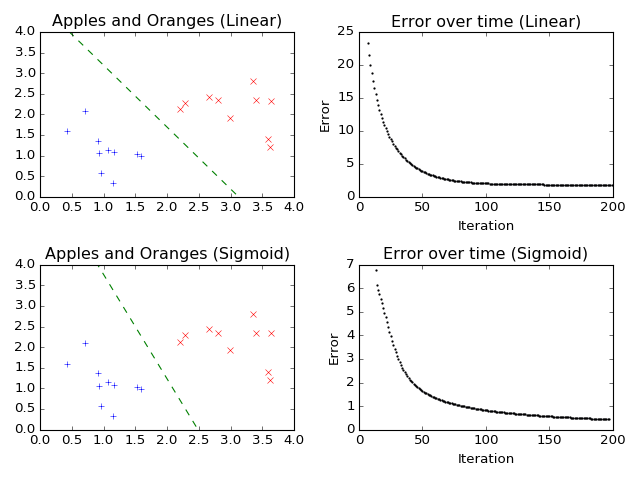

In [6]:
plotter.initPlotProb2()
optimizeSingle("Linear")
optimizeSingle("Sigmoid")

**Comment on the differences between the sigmoid and linear case.**

Both the sigmoid and linear case separate the apples and oranges. However, each case appears to converge to a different line with a different hyperplane slope. I believe this is because datapoints further from the hyperplane have a more important effect on the linear neuron because it's output $y$ is not saturated like in the sigmoid case. Strong outputs and weak outputs when passed through the sigmoid non-linearity do not look very different, and so in the sigmoid case an apple far to the right should not have a huge affect on the line relative to a closer one.

On the other hand, in the linear case the line seems to be pulled toward furthest apples to the right becuase they have a disproportionate affect on the error term.

<h2 align="center">3. Multilayer network </h2> 

Augment the data from question 2 with the additional datasets apples2.npy and oranges2.npy. As you can see from plotting out the combined data, the problem of discriminating the apples from the oranges is no longer linearly separable, so we must use a multilayer network for this problem. Start by deriving the learning rules for a two layer network. Then, train a two-layer network (using backprop) to learn to discriminate between apples and oranges. Use the code below to get started. Experiment with adding a momentum term to see if it helps with convergence.

To make sure your solution works, we have provided you with a good initialization of the weights (goodInit=True). After you get this solution working you should experiment with random initializations (goodInit=False). In the description of your solution you should comment on the following:

a) From your learned solution, describe in words how the two layers work together to discriminate between apples and oranges. <br/>
b) The effect momentum has on the learning <br/>
c) The solutions learned when goodInit=False and why they happen <br/>

** Derivation of Learning rules for a two-layer network **

$\vec{x} \rightarrow \textbf{W} \rightarrow \vec{y} \rightarrow \textbf{V} \rightarrow \vec{z}$

$z_i = \sigma(u_{z_i}) \qquad u_{z_i} = \sum\limits_{j} V_{ij} y_j$

$y_i = \sigma(u_{y_i}) \qquad u_{y_i} = \sum\limits_{j} W_{ij} x_j$

This derivation has a lot of indicies so gotta be careful. I will try index input nodes using $i$, hidden layer nodes by $j$, and and output nodes by $k$. Other indicies I will use that will drop out are $n$, $m$, and $l$.

** Learning Rule for Second Layer Weight Matrix **

First, learning rules for second layer $V$. Start with energy function.

$E^{\alpha} = \frac{1}{2} \sum\limits_{k} {\left[ z_k^{\alpha} - z_k(x^{\alpha}) \right] ^2}$

Diffrentiating with respect to the weight $V_{nm}$

$\frac{\partial{E^{\alpha}}}{\partial{V_{nm}}} = - \sum\limits_{n} {\left[ z_k^{\alpha} - z_k(x^{\alpha}) \right] } \frac{\partial{z_k}}{\partial{V_{nm}}}$

From the definition of $z$ above

$\frac{\partial{z_k}}{\partial{V_{nm}}} = \sigma'(u_{z_k}) \frac{\partial{u_{z_k}}}{\partial{V_{nm}}}$

And using the definition of $u_z$

$\frac{\partial{u_{z_k}}}{\partial{V_{nm}}} =
\sum\limits_{j} \frac{\partial{[V_{kj} y_j]}}{\partial{V_{nm}}} =
\sum\limits_{j} {\left[ V_{kj} \frac{\partial{y_j}}{\partial{V_{nm}}} + y_j \frac{\partial{V_{kj}}}{\partial{V_{nm}}}  \right]}
$

Now, this term $\frac{\partial{y_j}}{\partial{V_{nm}}}$ is always 0 because $y_j$ is not a function of its output weights $V$. The term $\frac{\partial{V_{kj}}}{\partial{V_{nm}}}$ is zero for all indicies except for the term where $k = n$ and $m = j$ where it is equal to 1. So that single term gets picked out of the sum and reindexing we get.


$\frac{\partial{u_{z_k}}}{\partial{V_{nj}}} = y_j$

Plugging back into the expression for $\frac{\partial{E^{\alpha}}}{\partial{V_{nj}}}$, and noting that $\frac{\partial{z_k}}{\partial{V_{nj}}}$ is only nonzero for $k=n$ we pick out that single term in the sum:

$\frac{\partial{E^{\alpha}}}{\partial{V_{kj}}} = - {\left[ z_k^{\alpha} - z_k(x^{\alpha}) \right] } \sigma'(u_{z_k}) y_j $

Thus, the learning rule for weight $V_{kj}$ is

$\boxed{
\Delta{V_{kj}} = \eta \sum\limits_{\alpha} { {\left[ z_k^{\alpha} - z_k(x^{\alpha}) \right] } \sigma'(u_{z_k}) y_j }
}$

** Learning Rule for First Layer Weight Matrix **

Will use the same method, taking the derivative of the energy function this time with respect to weight $W_{nm}$.

$\frac{\partial{E^{\alpha}}}{\partial{W_{nm}}} = - \sum\limits_{n} {\left[ z_k^{\alpha} - z_k(x^{\alpha}) \right] } \frac{\partial{z_k}}{\partial{W_{nm}}}$

From the definition of $z$ above (Terms involving $\frac{\partial{V_{kj}}}{\partial{W_{nm}}}$ drop out beacuse the weight matricies are independent of each other.)

$\frac{\partial{z_k}}{\partial{W_{nm}}} = 
\sigma'(u_{z_k}) \frac{\partial{u_{z_k}}}{\partial{W_{nm}}} =
\sigma'(u_{z_k}) \frac{\partial}{\partial{W_{nm}}} \left[ \sum\limits_{j} V_{kj} y_j \right] =
\sigma'(u_{z_k}) \sum\limits_{j} V_{kj} \frac{\partial{y_j}}{\partial{W_{nm}}}
$

From the definition of $y$ above

$\frac{\partial{y_j}}{\partial{W_{nm}}} = \sigma'(u_{y_j}) \frac{\partial{u_{y_j}}}{\partial{W_{nm}}}$

And using the definition of $u_y$

$\frac{\partial{u_{y_j}}}{\partial{W_{nm}}} =
\sum\limits_{i} \frac{\partial{[W_{ji} x_i]}}{\partial{W_{nm}}} =
\sum\limits_{i} {\left[ W_{ji} \frac{\partial{x_i}}{\partial{W_{nm}}} + x_i \frac{\partial{W_{ji}}}{\partial{W_{nm}}}  \right]}
$

Like in the previous derivation, $x_i$ is not a function of its output weights $W$ so $\frac{\partial{x_i}}{\partial{W_{nm}}} = 0$. The second term $\frac{\partial{W_{ki}}}{\partial{W_{nm}}}$ is equal to zero unless $j=n$ and $i=m$. This picks out the single $i=m$ term in this sum, and the $j=n$ term in our earlier expression for $\frac{\partial{z_k}}{\partial{W_{nm}}}$

$\frac{\partial{u_{y_j}}}{\partial{W_{ji}}} = x_i$

$\frac{\partial{y_j}}{\partial{W_{ji}}} = \sigma'(u_{y_j}) x_i$

$\frac{\partial{z_k}}{\partial{W_{ji}}} = 
\sigma'(u_{z_k}) V_{kj} \sigma'(u_{y_j}) x_i
$

Plugging back into our expression for the energy and multiplying by a learning rate $\eta$, our learning rate for the first layer is:

$\boxed{
\Delta{W_{ji}} = \eta \sum\limits_{\alpha} { {\left[ z_k^{\alpha} - z_k(x^{\alpha}) \right] } \sigma'(u_{z_k}) V_{kj} \sigma'(u_{y_j}) x_i}
}$

In [22]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import HyperPlanePlotter
import pdb

In [23]:
# Additionally load 'data/apples2.mat' and 'data/oranges2.mat'
apples  = np.load('data/apples.npy')
oranges = np.load('data/oranges.npy')
apples2 = np.load('data/apples2.npy')                                                                                                                                      
oranges2 = np.load('data/oranges2.npy')

# initialize data array
apples = np.hstack((apples, apples2))
oranges = np.hstack((oranges, oranges2))
data = np.hstack((apples, oranges))
dimensions,numSamples = data.shape
halfNumSamples = int(numSamples/2)

In [24]:
# initialize teacher
teacher = np.ones(numSamples)
teacher[halfNumSamples:] *= 0

# learning rate
eta=4e-1

# number of trials - you may want to make this smaller or larger
numTrials = 4000

# plotting
plotter = HyperPlanePlotter(data, apples, oranges, numTrials, halfNumSamples)
plotEvery  = numTrials // 50
plotErrorEvery = numTrials // 100

In [25]:
def sigmoid(u):
    return pow(1 + np.exp(-u), -1)

def sigmoidDeriv(u):
    return sigmoid(u) * (1 - sigmoid(u))

In [26]:
def optimizeMulti(goodInit=True, momentum=False):
    # initialize weights and biases
    weightsOne = np.load('init/weightsOne.npy') if goodInit else np.random.randn(2,2) # first layer weights                                                                                                                                        
    biasOne    = np.load('init/biasOne.npy') if goodInit else np.random.randn(2,1)                                                                                                                                                                 
    weightsTwo = np.load('init/weightsTwo.npy') if goodInit else np.random.randn(2,1) # second layer weights                                                                                                                                       
    biasTwo    = np.load('init/biasTwo.npy') if goodInit else np.random.randn(1)                                                                                                                                                                   
     
    # setup plots
    plotter.setupPlotProb3(weightsOne, biasOne, weightsTwo, biasTwo)

    momOne = np.zeros((2, 2))
    momOne0 = np.zeros((2, 1))
    momTwo = np.zeros((2, 1))
    momTwo0 = np.zeros(1)

    # initialize variables for momentum
    
    ## YOUR CODE HERE

    # loop over trials
    for t in range(numTrials):
        errorT = 0 
        # initialize derivative of weights, biases
        delta_w_one = np.zeros((2, 2))
        delta_w_one0 = np.zeros((2, 1))
        delta_w_two = np.zeros((2, 1))
        delta_w_two0 = np.zeros(1)

        # loop over training set
        for i in range(numSamples):
            # forward pass - compute y layer
            x = data[:, i, None]
            u_y = weightsOne.dot(x) + biasOne
            y = sigmoid(u_y)
            # forward pass - compute z layer
            u_z = weightsTwo.T.dot(y) + biasTwo
            z = sigmoid(u_z)
            
            # compute error
            err = teacher[i] - z
            
            # accumulate second layer derivatives
            modified_err_z = err * sigmoidDeriv(u_z)
            delta_w_two += eta * modified_err_z * y
            delta_w_two0 += eta * modified_err_z.reshape(1)
            
            # accumulate first layer derivatives
            modified_err_y = sigmoidDeriv(u_y) * weightsTwo.dot(modified_err_z)
            delta_w_one += eta * modified_err_y * x.T
            delta_w_one0 += eta * modified_err_y * np.ones((2, 1))

            # accumulate the error according the objective function into errorT
            errorT += pow(err, 2)
        
        # update weights and bias
        alpha = eta / 2
        weightsOne += delta_w_one + alpha * int(momentum) * momOne
        weightsTwo += delta_w_two + alpha * int(momentum) * momTwo
        biasOne += delta_w_one0 + alpha * int(momentum) * momOne0
        biasTwo += delta_w_two0 + alpha * int(momentum) * momTwo0

        # track previous weight derivatives to use momentum
        momOne = delta_w_one
        momTwo = delta_w_two
        momOne0 = delta_w_one0
        momTwo0 = delta_w_two0

        # update display of separating hyperplane at plotEvery intervals
        if t % plotEvery == 0:
            plotter.updatePlotProb3(weightsOne, biasOne, weightsTwo, biasTwo)
        if t % plotErrorEvery == 0:
            plotter.plotErrorProb3(t, errorT)

<IPython.core.display.Javascript object>


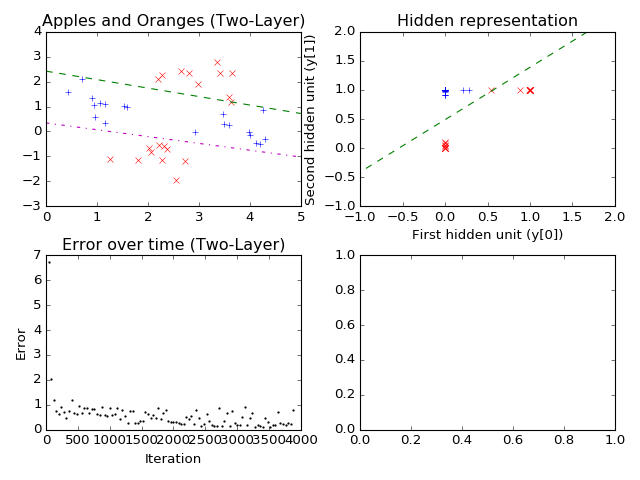

In [12]:
optimizeMulti(goodInit=True, momentum=False)

<IPython.core.display.Javascript object>


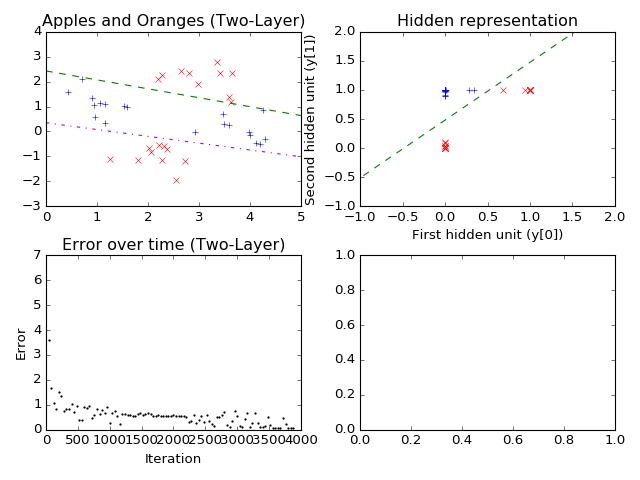

In [13]:
optimizeMulti(goodInit=True, momentum=True)

<IPython.core.display.Javascript object>


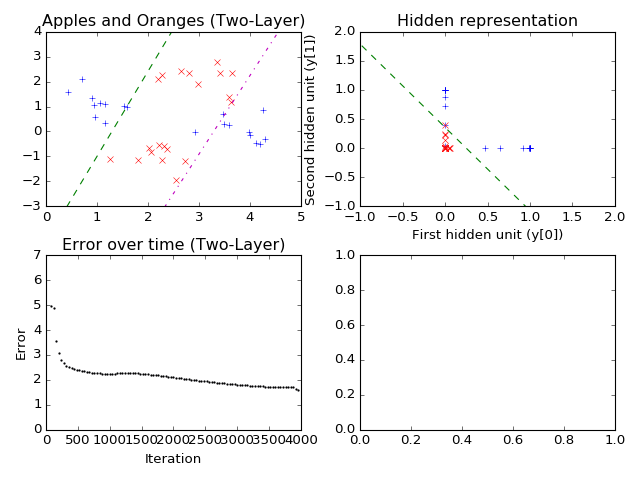

In [27]:
optimizeMulti(goodInit=False, momentum=True) # Run this many times

**YOUR TEXT HERE - Comment on the learned solution, the effect of momentum, and learned solution under random initializations** <br/>

The apples and orange are not linearly separable by a single hyperplane. The multilayer network tries to solve this by using two hyperplanes in the first layer, and adjusting them such that the blue datapoints lie between the hyperplanes and the red ones outside of both. One hidden layer unit encodes whether a point is above the first hyperplane, and the other one encodes if it above the second. The second layer can then divide these points in this new space by separating points at (0, 0) and (1, 1) (either above or below both hyperplanes) and a point at (1, 0) (above one and below the other). In this new space, the apples and oranges are linearly separable.

Momentum works by dampening oscillations around the error minima caused by a larger learning rate. It allows you to increase the learning rate to larger values which is particularly helpful if your initial state is far from a good solution.

When we randomly initialize the weight matricies and try to learn a solution, we can get unlucky and apparently settle in local minima that don't correspond to the best solution. In these cases, the network will do just a good enough job of separating the apples and oranges that moving the hyperplanes one way or another will make the error worse in the short term. To get the ideal solution would require a large pertubation to the weight matricies which isn't possible with the current learning rate. 

<h2 align="center">4. Pattern Discrimination Task </h2> 

Consider the following pattern discrimination task:

![title](img/lab2.4.png)

In this problem you will train a two-layer network to discriminate between these two patterns. First, make a hypothesis about what representation the first layer will learn in order to allow the second layer to discriminate between these two patterns. Then, train a two-layer neural network to discriminate between these patterns. How many hidden units are needed? What representation is learned by the hidden units in order to solve this problem? Comment on the differences between how you thought to discriminate between the patterns and how the network learned to.

*** YOUR TEXT HERE -- Make a hypothesis about what representation the first layer will learn***

To distinguish T from S, the network needs to find features that distinguish each type. One distinguishing factor is that in T, opposite corners have different values, but in S, opposite corners have the same value. I guess that the first layer will learn to represent whether opposite corners of the 9x9 grid are equal or not which would require one hidden unit to represent them both on, and one hidden unit to represent them both off.

In [28]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import FilterPlotter
import pdb

In [29]:
# initialize data array
S = np.load('data/S.npy')
T = np.load('data/T.npy')
data = np.hstack((S,T))
numInputUnits,numSamples = data.shape
halfNumSamples = int(numSamples/2)

In [30]:
# initialize teacher
teacher = np.ones(numSamples)
teacher[halfNumSamples:] *= 0

# learning rate
eta=4e-1

# number of trials - you may want to make this smaller or larger
numTrials = 2000

# plotting
plotter = FilterPlotter(numTrials)
plotHiddenUnitsEvery  = numTrials // 20
plotErrorEvery = numTrials // 50

In [31]:
def sigmoid(u):
    return pow(1 + np.exp(-u), -1)

def sigmoidDeriv(u):
    return sigmoid(u) * (1 - sigmoid(u))

In [32]:
def optimizeMultiPattern(numHiddenUnits, momentum=False):
    # initialize weights and biases
    weightsOne = np.random.randn(numHiddenUnits, numInputUnits) # first layer weights                                                                                                                                        
    biasOne    = np.random.randn(numHiddenUnits,1)                                                                                                                                                                 
    weightsTwo = np.random.randn(numHiddenUnits,1) # second layer weights                                                                                                                                       
    biasTwo    = np.random.randn(1)
    plotter.setupPlots(weightsOne, numHiddenUnits)
        
    # initialize variables for momentum

    weightsOneDerivLast = 0; biasOneDerivLast = 0; weightsTwoDerivLast = 0; biasTwoDerivLast = 0
    # loop over trials
    for t in range(numTrials):
        # initialize derivative of weights, biases, and error array for each trial                                                                                                                                                                    
        errorT = 0
        
        # initialize derivative of weights, biases
        delta_w_one = np.zeros((numHiddenUnits, numInputUnits))
        delta_w_one0 = np.zeros((numHiddenUnits, 1))
        delta_w_two = np.zeros((numHiddenUnits, 1))
        delta_w_two0 = np.zeros(1)

        # loop over training set
        for i in range(numSamples):
            # forward pass - compute y layer
            x = data[:, i].reshape((numInputUnits, 1))
            u_y = weightsOne.dot(x) + biasOne
            y = sigmoid(u_y)
            # forward pass - compute z layer
            u_z = weightsTwo.T.dot(y) + biasTwo
            z = sigmoid(u_z)
            
            # compute error
            err = teacher[i] - z
            
            # accumulate second layer derivatives
            modified_err_z = err * sigmoidDeriv(u_z)
            delta_w_two += eta * modified_err_z * y
            delta_w_two0 += eta * modified_err_z.reshape(1)
            
            # accumulate first layer derivatives
            modified_err_y = sigmoidDeriv(u_y) * weightsTwo.dot(modified_err_z)
            delta_w_one += eta * modified_err_y * x.T
            delta_w_one0 += eta * modified_err_y * np.ones((numHiddenUnits, 1))

            # accumulate the error according the objective function into errorT
            errorT += pow(err, 2)
            
        # update weights and bias
        alpha = eta / 2
        weightsOne += delta_w_one + alpha * int(momentum) * weightsOneDerivLast
        weightsTwo += delta_w_two + alpha * int(momentum) * weightsTwoDerivLast
        biasOne += delta_w_one0 + alpha * int(momentum) * biasOneDerivLast
        biasTwo += delta_w_two0 + alpha * int(momentum) * biasTwoDerivLast

        # track previous weight derivatives to use momentum
        weightsOneDerivLast = delta_w_one
        weightsTwoDerivLast = delta_w_two
        biasOneDerivLast = delta_w_one0
        biasTwoDerivLast = delta_w_two0
                
        # update display after plot*Every intervals
        if t % plotHiddenUnitsEvery == 0:
            plotter.updatePlots(weightsOne)
        if t % plotErrorEvery == 0:
            plotter.plotError(t, errorT)
    print ("Final Error: %.2f" % errorT)

<IPython.core.display.Javascript object>


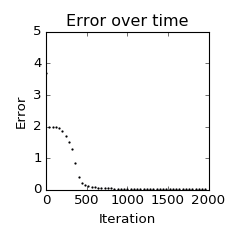

<IPython.core.display.Javascript object>


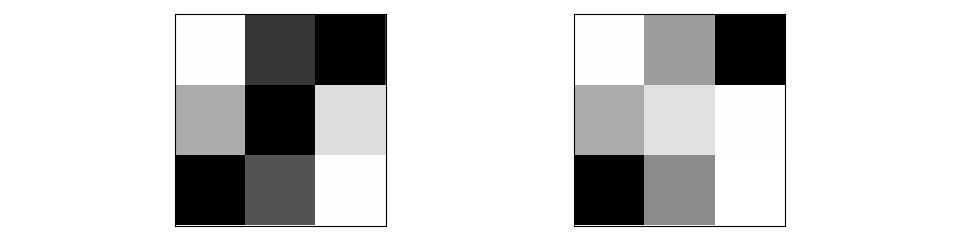

Final Error: 0.01


In [33]:
optimizeMultiPattern(numHiddenUnits=2, momentum=False) ## YOUR CODE HERE - Try different numbers of hidden units

*** YOUR TEXT HERE -- Comment on the number of hidden units needed and the differences between your hypothesis and results ***

It turns out, one hidden cannot separate T's and S's, but two or more hidden units can. Two is really all that is needed but adding three or four hidden units can help the network find a solution much faster. 

My hypothesis that it would look at opposite corners being equal was incorrect (although for some solutions it seems to be part of the hidden units' computation). What looks like is happening is that the two hidden units are checking two features that together can determine S or T.